# Eyetracking-DataProcess-MLclassification
Dataprocessing of eye-tracking raw data for Classification models 

**Project Context and Objective**  

Based on eye-tracking data from 192 laboratory experiments, this acadamic project of my Master programme in Polytech Nantes aims to practice the data processing, exploratory analysis and features research to build highe performance classifiers ML models to recognise the type of activities.  

**Data Description**  

The dataset consists of eye-tracking experiments involving 24 participants, each performing 8 activities (Read, Watch, Browse, Search, Play, Interpret, Debug, Write) on a L1920xW1080 size screen, with three variations of each activity to ensure greater behavioral diversity and minimize the influence of the stimulus on classification.  Each CSV file corresponds to an experiment conducted by a specific participant for a given activity, resulting in a total of 192 CSV files. Each file contains real-time eye-tracking system records of the x and y coordinates of screen points where the gaze is focused. Below is an example:  

## 1. Processing Raw Data to extract eye trajectories  

### 1.1 Review and description of raw data

In [2]:
# Analyse et manipulation des données
import pandas as pd
import numpy as np
import os 
import random
# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Example of one of the 192 rawdata file to have a review of the data
path = './data/raw_data_5mins'
file_list = os.listdir(path)
random_file = random.choice(file_list) # choose randomly one file 
datasample = pd.read_csv(path + '/' + random_file, sep=',').sort_values(by='timestamp')
datasample.tail()

,participant,set,activity,x,y,timestamp
7340,P17,B,PLAY,1099,476,299856
7341,P17,B,PLAY,1086,472,299886
7342,P17,B,PLAY,1076,482,299919
7343,P17,B,PLAY,1084,491,299950
7344,P17,B,PLAY,1087,467,299980


<Axes: xlabel='x', ylabel='y'>

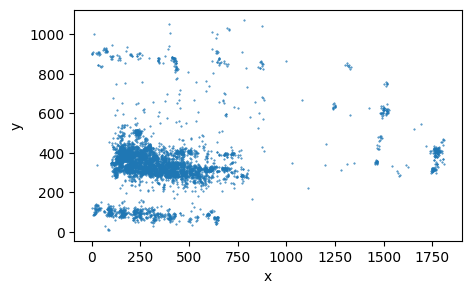

In [4]:
# visualization of gazes points in a randomly chosen file 
datasample = pd.read_csv(path + '/' + random.choice(os.listdir(path)), sep=',').sort_values(by='timestamp')
insideScreen = (0<=datasample['x']) & (datasample['x']<=1920) & (0<=datasample['y']) & (datasample['y']<=1080)
datasample[insideScreen].plot.scatter(x='x',y='y',s=0.2,figsize=(5,3))

**Remark:** The points out side of the dimension of screen should be deleted

**data sémtique:** 
- Chaque ligne représente un point sur l'écran, qui s'évolue dans le temps. 
- Variables x et y représente les coordonées X,Y du point sur l'écrans où est prêté attention du regard. 
- Variables timestamp: info temporelle d'expérience
- Les lignes, dans l'ensemble représente une séquence des points enregistrés pour une expérience sous certaines conditions. 7160 lignes veut dire il y a 7160 fois de enregestration pendant cette expérience. 

### 1.2 Extract of fixations dataset from raw data

**Concept "Fixation" & "Saccade"** 

![fixation and saccade](https://www.researchgate.net/profile/Robert-Krueger-3/publication/313805602/figure/fig2/AS:613955038871552@1523389696029/Eye-tracking-trajectories-consist-of-fixations-and-saccades-When-a-human-focuses-on.png)

Fixation : 

Saccade : 

**Question : How to extract patterns from eye movement data relies on statistics of different macro-events such as fixations and saccades ?**

**Function for Fixations Extraction**

In [5]:
## Function of extraction by a file 
def extract_fixations_byfile(maxD,minT,datapath,datafile) : 
    """Function to extract fixations by file in a given folder path

    Paramètres : 
    maxdist  : maximum distance between the points in a FIXATION
    mindur  : minimum duration passed for a group de points be recognised as FIXATION 
    datafile : data filename """
    ## introduction comme dataframe dans l'ordre de timestamp
    rawdata = pd.read_csv(datapath +'/'+ datafile, sep=',')
    ## Filte Only the points in the boundary of the screen
    insideScreen = (0<=rawdata['x']) & (rawdata['x']<=1920) & (0<=rawdata['y']) & (rawdata['y']<=1080)
    rawdata = rawdata[insideScreen].sort_values('timestamp').reset_index(drop=True) # reindex in order of time
    # input de départ
    time = rawdata.timestamp
    x = rawdata.x
    y = rawdata.y

    ## étape-1 : iteration pour détécter tous les segment dont tous les deux point enchaînés ont une distance inférieur à 'maxdist'
    segment = [] ## contain 4 elements : (index,startT, endT , numberofpoints)
    # _inition_
    time_start = time[0] # First supposed point
    Nbpt = 1           # counter it as the first
    for i in range(1,len(time)) :
        dist = ((x[i]-x[i-1])**2 + (y[i]-y[i-1])**2)**0.5
        if dist <=  maxD : # si il satisfait le critère
            time_end = time[i] # 
            Nbpt = Nbpt + 1 # counte the points 
        else:
            # sinon terminer 
            time_end = time[i-1] # fermer le segment and rejeter le point actuel
            segment.append([i, time_start, time_end, Nbpt])
            # _réinition_
            time_start = time[i]
            Nbpt = 1

    ## étape-2 : filtrer les segment en fonction de la durée
    # output prévu
    data = [] # matrix
    for seg in segment :
        index = seg[0]
        duration =seg[2] - seg[1]
        Numberpoint = seg[3]
        if duration >= minT :
            x_centre = x[index]
            y_centre = y[index]
            data.append([seg[1], seg[2], duration, Numberpoint, x_centre, y_centre])
    
    ## mis en dataframe avec les nomes de colonnes 
    df = pd.DataFrame(data=data,columns=['time_start','time_end','fixaTime','Nbpt','x_centre','y_centre'])

    ## add 3 colomns at the end for user experience infos and then reorder them
    lst_keycols = rawdata.columns[:-3].to_list()
    for col in lst_keycols :
        # for each col, creat a new colomns in the df with correspondant value in rawdata
        df[col] = rawdata[col].unique()[0]
    # Specify the desired order
    colomns_neworder = lst_keycols + list(df.columns[:-3])  
    # Reorder columns
    df = df[colomns_neworder]

    ## output dataframe
    return df

In [6]:
## Function to combine all extraction by file
def Exact_concatenate_Fixa_ofAllfiles(maxD,minT,path) :
    import os 
    file_list = os.listdir(path)
    fixation = None
    for f in range(0, len(file_list)) :
        df_file = extract_fixations_byfile(maxD, minT,path, datafile=file_list[f])
        fixation = pd.concat([fixation,df_file])

    return fixation

**Extraction by functions of all the raw datafiles in the fold**

In [7]:
# extraction de toutes les expériences avec une critère 
allFixa_D75T50 = Exact_concatenate_Fixa_ofAllfiles(maxD= 75,
                                                   minT=50,
                                                   path='./data/raw_data_5mins') 
allFixa_D75T50

,participant,set,activity,time_start,time_end,fixaTime,Nbpt,x_centre,y_centre
0,P01,B,BROWSE,0,1037,1037,31,715,939
1,P01,B,BROWSE,1956,2141,185,7,1062,283
2,P01,B,BROWSE,2202,2505,303,11,1354,507
3,P01,B,BROWSE,4338,4533,195,7,589,1067
4,P01,B,BROWSE,4899,5254,355,9,1640,68
...,...,...,...,...,...,...,...,...,...
227,P24,B,WRITE,292414,292575,161,3,135,472
228,P24,B,WRITE,292614,292687,73,2,48,603
229,P24,B,WRITE,292777,293103,326,6,7,725
230,P24,B,WRITE,294721,298957,4236,3,191,591


### 1.3 Extract of Saccades in extracted Fixation dataset and add them to it

#### Definition of automatic extraction functions

In [8]:
## Functions for saccades extraction and addition to fixation dataframe
import numpy as np
def extractSaccads_andAddto_fixDataFrame_By(participant,activity,dataFrame) :
    """Extraction of saccades feutures by participant and activity,based on the extracted fixation data"""
    ## query of data for the input participant and activity key
    df_fix = dataFrame[ (dataFrame['participant']==participant) 
                                  & (dataFrame['activity']==activity) ]
    df_fix = df_fix.sort_values('time_start').reset_index(drop=True) # make sure: the index is in order of time

    ## Variables and 
    # creation of new columns for features values to extract
    df_fix[['saccTime','Amlplitude','vectorX','vectorY','angleAbs180','angleAbs360','angleRela180']] = None
    
    # extraire des colonnes spécifiques avant la boucle pour réduire les appels à 'df.loc'
    startTimes = df_fix['time_start']
    endTimes = df_fix['time_end']
    centresX = df_fix['x_centre']
    centresY = df_fix['y_centre']
    
    ## Extraction in boucle line by line
    pre_angle  = 0  # for a reference to calculate the first relative angle
    for idx in df_fix.index :
        # for the current line of index number 'idx'
        current_startTime = startTimes[idx]
        # find out next timestamp, which is the follozing value [time_start] in the sequence of timestamp
        next_startTime = find_next_timestamp(startTimes,current_startTime)
        if next_startTime != None : 
            ## if it is findable, which means this is not the last point 

            #1 find out the line where the value [time_start] is the next timestamp
            nextIdx = (df_fix[df_fix['time_start']==next_startTime].index)[0]

            #2 calculate the vector from the current pont to the next point
            X_current, Y_current = centresX[idx], centresY[idx]
            X_next, Y_next = centresX[nextIdx], centresY[nextIdx]
            vectorX,vectorY = (X_next - X_current), (Y_next - Y_current)

            #3 with the vector,caculate the amplitude et vilocity 
            Amlplitude = np.sqrt( vectorX**2 + vectorY**2 )
            saccTime = next_startTime - endTimes[idx]
            # saccVelocity = Amlplitude / saccTime

            #4 angle absolute 180/360
            cos_Abs = np.dot([vectorX,vectorY],[1,0]) / Amlplitude    
            angleAbs180 = np.rad2deg(np.arccos(cos_Abs)) 
            if vectorY < 0:
                angleAbs360 = 360 - angleAbs180
            else:
                angleAbs360 = angleAbs180

            #4 angle relative 180
            angleRela180 = abs(angleAbs360 - pre_angle) #% 360
            if angleRela180 > 180:
                angleRela180 = 360 - angleRela180

            # reinitiation 
            pre_angle = angleAbs360

            ## creation culumns and affectuation of values in the created culumns
            df_fix.loc[idx,'saccTime'] = saccTime
            df_fix.loc[idx,'Amlplitude'] = Amlplitude  
            df_fix.loc[idx,'vectorX'] = vectorX 
            df_fix.loc[idx,'vectorY'] = vectorY
            df_fix.loc[idx,'angleAbs180'] = angleAbs180
            df_fix.loc[idx,'angleAbs360'] = angleAbs360
            df_fix.loc[idx,'angleRela180'] = angleRela180

    return df_fix

# function for function
def find_next_timestamp(liste, valeur):
    """
    Automaticly find the next timestamp in a siquence of timestamp values
    """
    # Filtrer les valeurs strictement supérieures à la valeur donnée
    valeurs_superieures = [x for x in liste if x > valeur]
    # Si aucune valeur ne correspond, retourner None
    if not valeurs_superieures:
        return None
    # Retourner la plus petite valeur parmi les valeurs supérieures
    return min(valeurs_superieures)

#### Extraction of all saccades and combine ti fixation dataset

In [9]:
## Boucle to extract all saccades for the whole dataframe
participantList = list(allFixa_D75T50['participant'].unique())
activitiesList = list(allFixa_D75T50['activity'].unique())

## input 
df_allFixaSaccs = None 
for parti in participantList :
    for acti in activitiesList : 
        # extact of the next dataframe
        df_extract = extractSaccads_andAddto_fixDataFrame_By(participant= parti, 
                                                             activity= acti, 
                                                             dataFrame= allFixa_D75T50).dropna() 
        # and then contactation of the two
        df_allFixaSaccs = pd.concat([df_allFixaSaccs,df_extract])

df_allFixaSaccs

C:\Users\pengd\AppData\Local\Temp\ipykernel_24900\527404951.py:44: RuntimeWarning: invalid value encountered in scalar divide
  cos_Abs = np.dot([vectorX,vectorY],[1,0]) / Amlplitude
C:\Users\pengd\AppData\Local\Temp\ipykernel_24900\527404951.py:44: RuntimeWarning: invalid value encountered in scalar divide
  cos_Abs = np.dot([vectorX,vectorY],[1,0]) / Amlplitude


,participant,set,activity,time_start,time_end,fixaTime,Nbpt,x_centre,y_centre,saccTime,Amlplitude,vectorX,vectorY,angleAbs180,angleAbs360,angleRela180
0,P01,B,BROWSE,0,1037,1037,31,715,939,919,742.121958,347,-656,62.122798,297.877202,62.122798
1,P01,B,BROWSE,1956,2141,185,7,1062,283,61,368.021738,292,224,37.492653,37.492653,99.615451
2,P01,B,BROWSE,2202,2505,303,11,1354,507,1833,948.063816,-765,560,143.794897,143.794897,106.302244
3,P01,B,BROWSE,4338,4533,195,7,589,1067,366,1450.035172,1051,-999,43.546955,316.453045,172.658148
4,P01,B,BROWSE,4899,5254,355,9,1640,68,227,65.115282,-12,64,100.619655,100.619655,144.166611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,P24,B,WRITE,289115,289220,105,2,0,592,3194,180.623919,135,-120,41.633539,318.366461,144.126094
227,P24,B,WRITE,292414,292575,161,3,135,472,39,157.25775,-87,131,123.589017,123.589017,165.222556
228,P24,B,WRITE,292614,292687,73,2,48,603,90,128.705089,-41,122,108.575724,108.575724,15.013292
229,P24,B,WRITE,292777,293103,326,6,7,725,1618,227.622494,184,-134,36.064386,323.935614,144.640111


#### Output extracted gaze Dataset 

In [10]:

df_allFixaSaccs.to_csv('./data/Extracted_GazeData_FixationSaccades.csv',index=False)

## 2. Visualisation of fixation and saccades

### 2.1 Standalone Visualisation

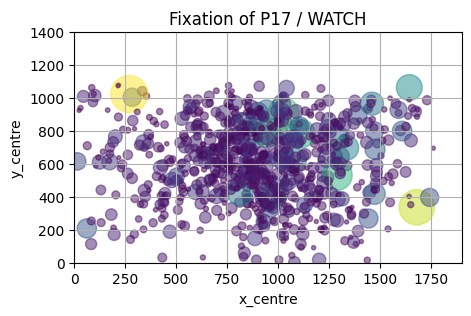

In [11]:
## standalone visualisation
def fixaViz_standalone(participant,activity,dataFrame):
    """visualisation of the fixations of certain activity by certain participant"""
    ## Data Query of certain activity by certain participant
    df = dataFrame[ (dataFrame['participant']==participant) & 
                   (dataFrame['activity']==activity) ]
    longscreen, widthscreen = 1900,1400
    size = df['fixaTime'] / df['fixaTime'].median() *(widthscreen/40)
    colors = df['fixaTime'] 
    
    fig,ax = plt.subplots(figsize =(5,3))
    ax.scatter('x_centre', 'y_centre', s=size, c=colors, data=df, alpha=0.5)

    ax.set(xlim=[0, longscreen], ylim=[0,widthscreen],xlabel='x_centre', ylabel='y_centre',
       title='Fixation of {} / {}' .format(participant,activity))
    ax.grid(True)
    plt.show()

## 
fixaViz_standalone('P17','WATCH',df_allFixaSaccs)

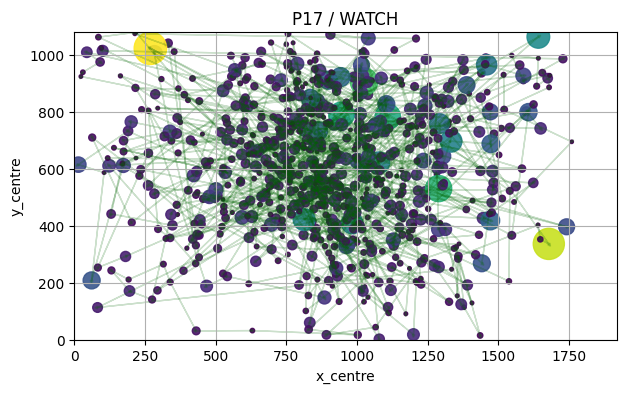

In [12]:
def fixaSaccadViz_standalone(participant,activity,data):
    """visualisation of the fixations of certain activity by certain participant"""
    df = data[ (data['participant']==participant) & 
                   (data['activity']==activity) ].sort_values('time_start').reset_index(drop=True)
    longscreen, widthscreen = 1920,1080
    size = df['fixaTime'] / df['fixaTime'].median() *(widthscreen/40)
    colors = df['fixaTime'] 

    fig,ax = plt.subplots(figsize =(7,4))

    ax.scatter('x_centre', 'y_centre', s=size, c=colors, data=df, alpha=0.9)

    for i in range(len(df.index)-1) :
        if(df.index[i+1] != 0) : 
            ax.arrow(df.x_centre[i], df.y_centre[i], 
                     df.x_centre[i+1]-df.x_centre[i], df.y_centre[i+1]-df.y_centre[i], 
                     width=0.02,color='darkgreen',head_length=10.0,head_width=10.0,alpha=0.2)

    ax.set(xlim=[0, longscreen], ylim=[0,widthscreen],xlabel='x_centre', ylabel='y_centre',
       title='{} / {}' .format(participant,activity))
    ax.grid(True)
    plt.show()

## application
fixaSaccadViz_standalone('P17','WATCH',df_allFixaSaccs)

### 2.2 Compared Visualisation

#### Fixation 

C:\Users\pengd\AppData\Local\Temp\ipykernel_24900\257732515.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


presse the button again to refresh and choose anothers 3 participant


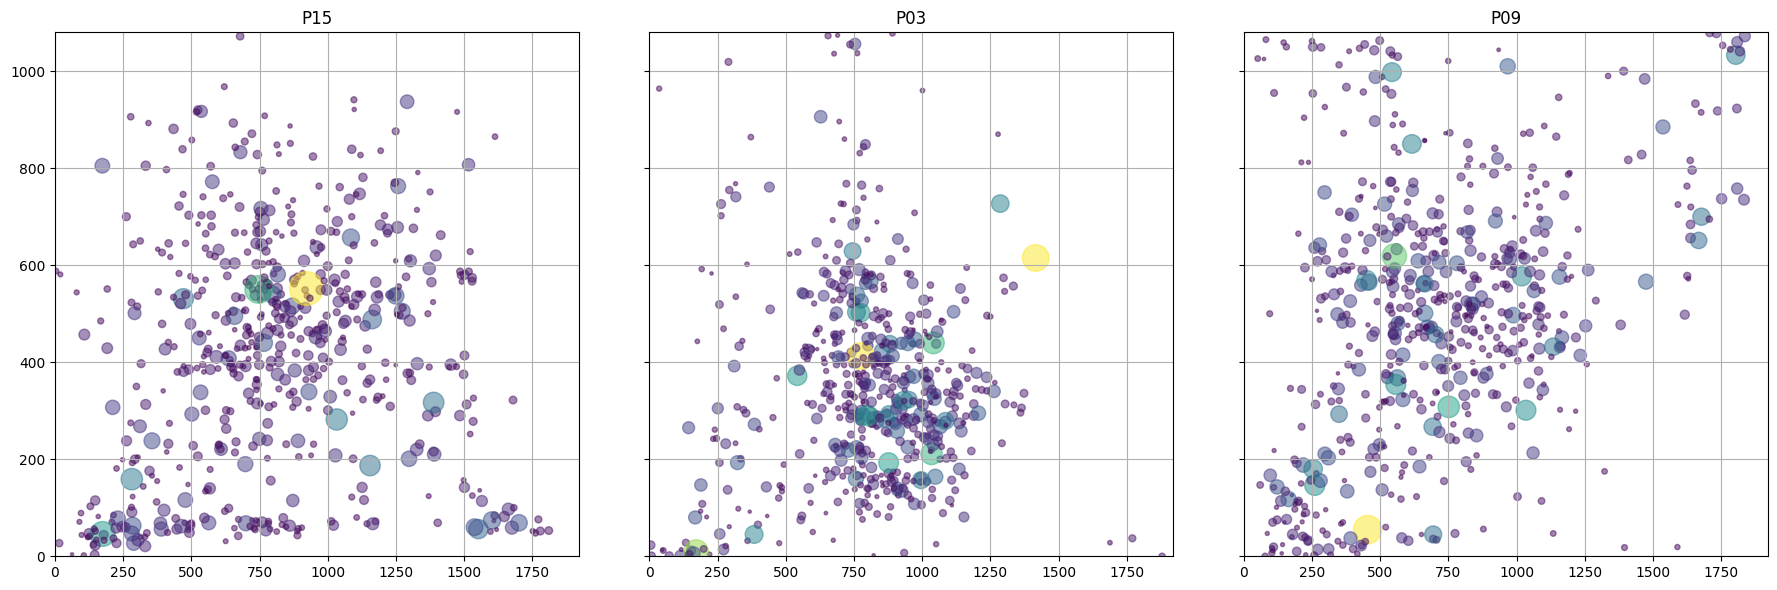

In [13]:
## Between 3 Fixation of the same type of activity
def fixaViz_compare_1acti3person(activity,allFixa): 
    """Afficher les fixations pour toutes les 8 activites par un participant aléatoire """
    import random
    sujets = list(allFixa.participant.unique())
    sujets_rd = random.sample(sujets,3)

    fig, axs = plt.subplots(1, 3, subplot_kw=dict(box_aspect=1),
                             sharex=True, sharey=True,layout='constrained',figsize=(19,6))

    longscreen, widthscreen = 1920,1080
    for suj, ax in enumerate(axs.flat):
        df = allFixa[ (allFixa['participant']== sujets_rd[suj]) 
                     & (allFixa['activity']==activity) ].sort_values('time_start').reset_index(drop=True)
        size = df['fixaTime'] / df['fixaTime'].median() *(widthscreen/40)
        colors = df['fixaTime'] 
        ax.scatter('x_centre', 'y_centre', s=size, c =colors, data=df, alpha=0.5)
        ax.set(xlim=[0, longscreen], ylim=[0,widthscreen],title='{}'.format(sujets_rd[suj]))
        ax.margins(x=0,y=0)
        ax.grid(True)
        fig.tight_layout()
    print("presse the button again to refresh and choose anothers 3 participant")
    plt.show()

## choose one activity and show it of 3 random participants
fixaViz_compare_1acti3person(activity='BROWSE',allFixa=df_allFixaSaccs)

C:\Users\pengd\AppData\Local\Temp\ipykernel_24900\170680386.py:20: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


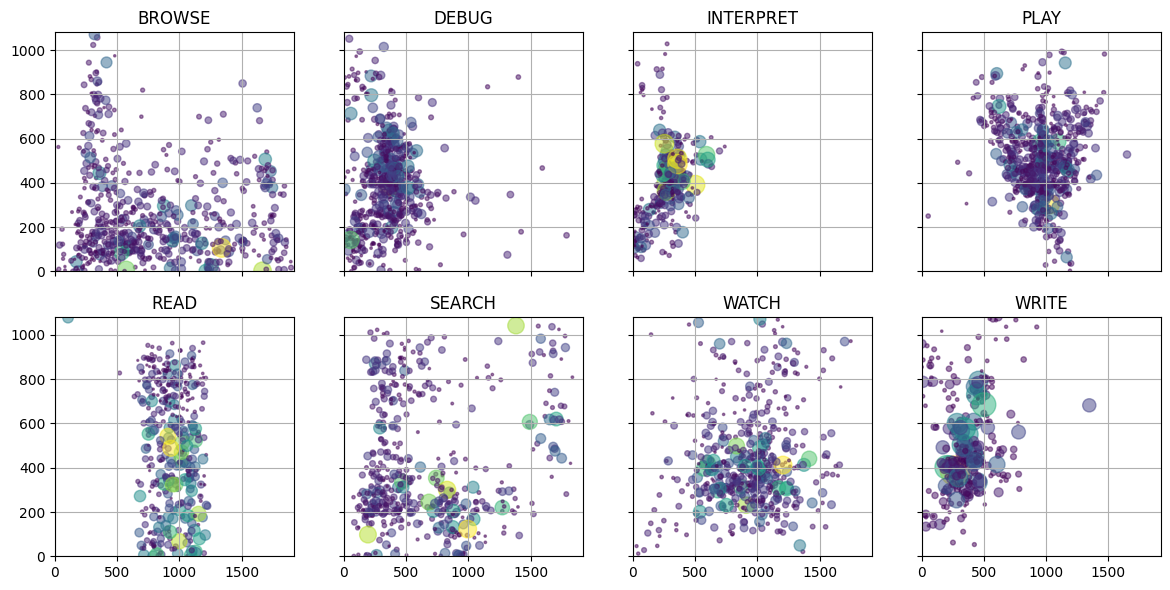

In [14]:
def fixaViz_compare_8actis(gazedata): 
    """Afficher les fixations pour toutes les 8 activites par un participant aléatoire """
    import random
    sujets = list(gazedata.participant.unique())
    activities = list(gazedata.activity.unique())
    sujet_radom = random.choice(sujets)

    fig, axs = plt.subplots(2, 4, subplot_kw=dict(box_aspect=1),
                             sharex=True, sharey=True,layout='constrained',figsize=(20,6))

    longscreen, widthscreen = 1920,1080
    for i, ax in enumerate(axs.flat):
        df = gazedata[ (gazedata['participant']== sujet_radom) & (gazedata['activity']==activities[i])]
        size = df['fixaTime'] / df['fixaTime'].median() *(widthscreen/80)
        colors = df['fixaTime'] 
        ax.scatter('x_centre', 'y_centre', s=size, c =colors, data=df, alpha=0.5)
        ax.set(xlim=[0, 1900], ylim=[0,1400],title='{}'.format(activities[i]))
        ax.margins(x=0,y=0)
        ax.grid(True)
        fig.tight_layout()

    plt.axis([0, longscreen, 0, widthscreen])
    plt.show()

## visualiser 8 activités aléatoire pour un participant aléatoire
fixaViz_compare_8actis(df_allFixaSaccs)

#### Fixation and Saccades 

C:\Users\pengd\AppData\Local\Temp\ipykernel_24900\570414538.py:28: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


presse the button again to refresh and choose anothers 3 participant


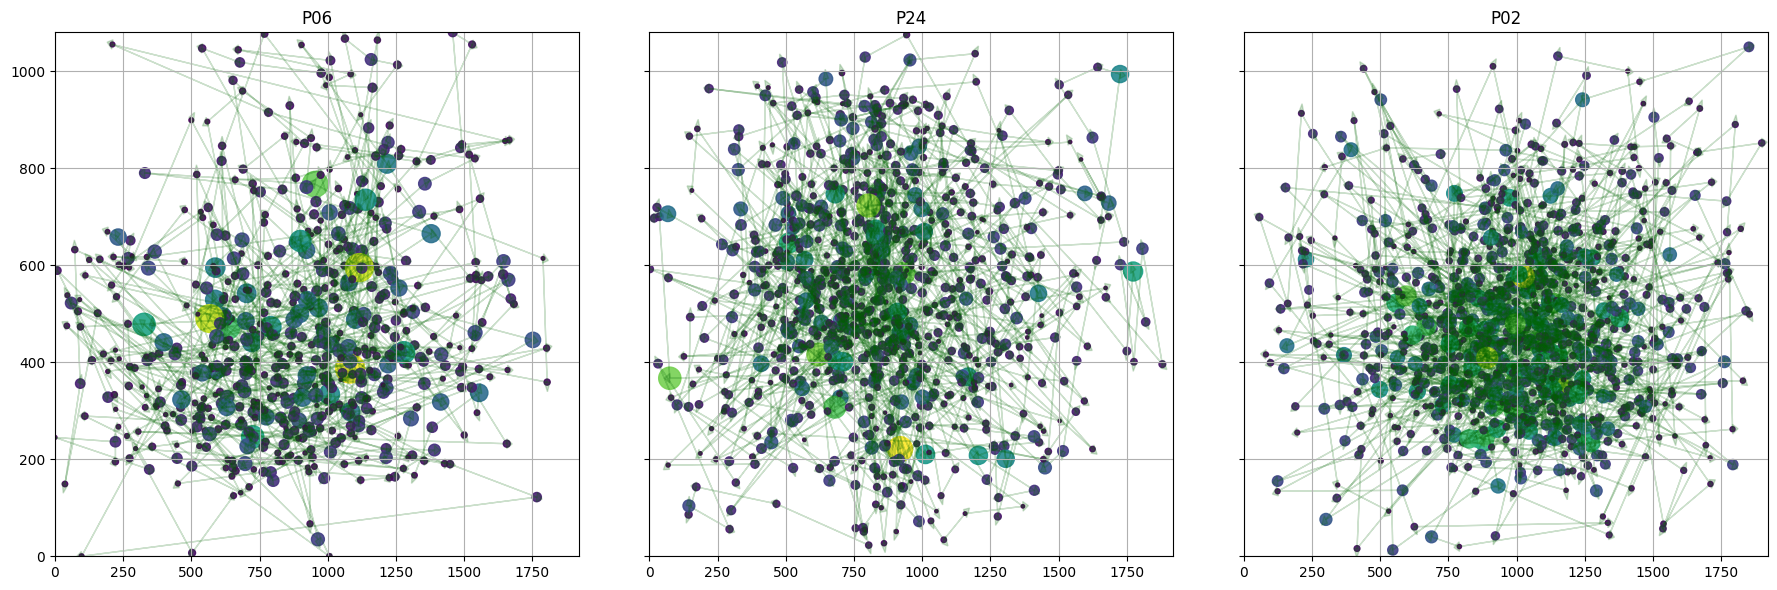

In [15]:
def fixaSaccaViz_compare_1acti3person(activity,data): 
    """Afficher les fixations pour toutes les 8 activites par un participant aléatoire """
    import random
    sujets = list(data.participant.unique())
    sujets_rd = random.sample(sujets,3)

    fig, axs = plt.subplots(1, 3, subplot_kw=dict(box_aspect=1),
                             sharex=True, sharey=True,layout='constrained',figsize=(19,6))

    longscreen, widthscreen = 1920,1080
    for suj, ax in enumerate(axs.flat):
        df = data[ (data['participant']== sujets_rd[suj]) 
                     & (data['activity']==activity) ].sort_values('time_start').reset_index(drop=True)

        size = df['fixaTime'] / df['fixaTime'].median() *(widthscreen/40)
        colors = df['fixaTime']  / df['fixaTime'].median() 
        ax.scatter('x_centre', 'y_centre', s=size, c =colors, data=df, alpha=0.9)

        for i in range(len(df.index)-1) :
            if(df.index[i+1] != 0) : 
                ax.arrow(df.x_centre[i], df.y_centre[i], 
                         df.x_centre[i+1]-df.x_centre[i], df.y_centre[i+1]-df.y_centre[i], 
                         width=0.02,color='darkgreen',head_length=20.0,head_width=20.0,alpha=0.2)

        ax.set(xlim=[0, longscreen], ylim=[0,widthscreen],title='{}'.format(sujets_rd[suj]))
        ax.margins(x=0,y=0)
        ax.grid(True)
        fig.tight_layout()
    print("presse the button again to refresh and choose anothers 3 participant")
    plt.show()

## application de function
fixaSaccaViz_compare_1acti3person("WATCH",df_allFixaSaccs)

C:\Users\pengd\AppData\Local\Temp\ipykernel_24900\4076808229.py:32: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


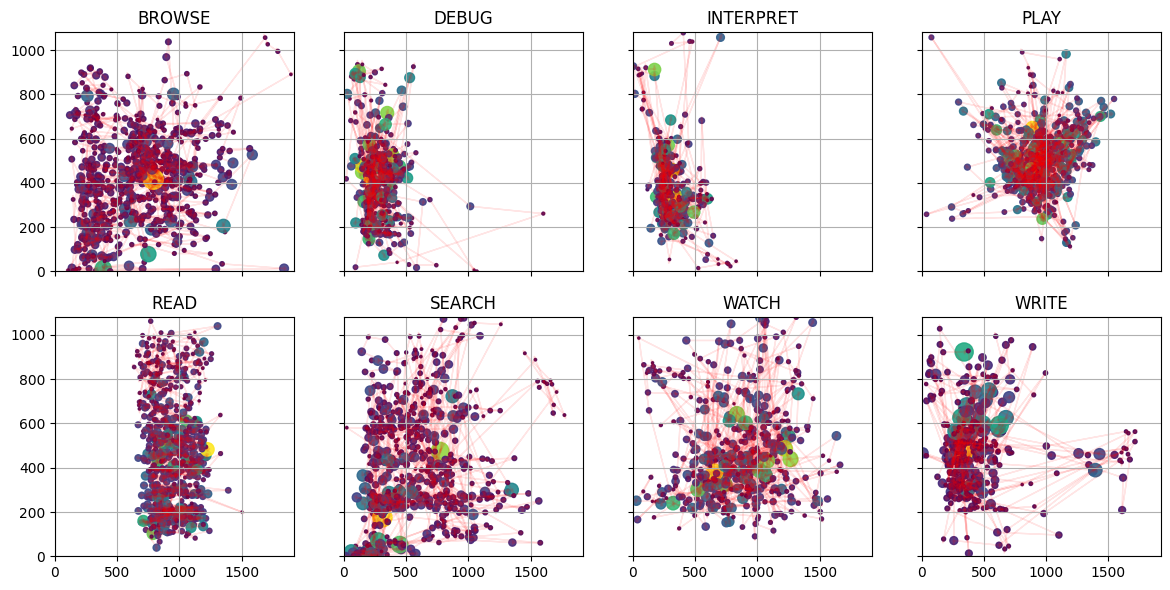

In [17]:
def Viz_FixaSacc_compare8actis(gazedata): 
    """Afficher les fixations pour toutes les 8 activites par un participant aléatoire """
    import random
    #sujet randomly choosed
    sujets = list(gazedata.participant.unique())
    sujet_radom = random.choice(sujets)
    # list af all 8 activity
    activities = list(gazedata.activity.unique())
    # create plot and subplot
    fig, axs = plt.subplots(2, 4, subplot_kw=dict(box_aspect=1),
                             sharex=True, sharey=True,layout='constrained',figsize=(20,6))

    ## Boucle for each of the 8 activities
    longscreen, widthscreen = 1920,1080
    for j, ax in enumerate(axs.flat):
        # Query of dataframe
        df = gazedata[ (gazedata['participant']== sujet_radom) & (gazedata['activity']==activities[j])]
        # points of Fixation
        size = df['fixaTime'] / df['fixaTime'].median() *(widthscreen/80)
        colors = df['fixaTime'] 
        ax.scatter('x_centre', 'y_centre', s=size, c =colors, data=df, alpha=0.9)
        # vectors of Saccades
        for i in range(len(df.index)-1) :
            if(df.index[i+1] != 0) : 
                ax.arrow(df.x_centre[i], df.y_centre[i], 
                         df.x_centre[i+1]-df.x_centre[i], df.y_centre[i+1]-df.y_centre[i], 
                         width=0.02,color='red',head_length=20.0,head_width=20.0,alpha=0.1)
        # ax configurations
        ax.set(xlim=[0, 1900], ylim=[0,1400],title='{}'.format(activities[j]))
        ax.margins(x=0,y=0)
        ax.grid(True)
        fig.tight_layout()

    plt.axis([0, longscreen, 0, widthscreen])
    plt.show()

### Application of Function
Viz_FixaSacc_compare8actis(gazedata=df_allFixaSaccs)

## Write this process in Python Module 